<img align="left" width="20%" style="padding-right:10px;" src="./Images/Ccom.png"> 

# Integrated Seabed Mapping Systems <a href="https://teams.microsoft.com/l/channel/19%3a324bf45414fd4b408d01baaac7041425%40thread.tacv2/Lab%2520C?groupId=bc882690-9b4e-4f3e-9b51-36f1367b8198&tenantId=d6241893-512d-46dc-8d2b-be47e25f5666"><img src="./Images/help.png"  title="Ask questions on Teams" align="right" width="10%" ></a>

# Lab C: Performance Envelope
<br><br><br>
___

___
This lab is designed to encourage you to implement your own prediction of the performance envelope of a multi-beam sonar system.

Using the Sonar Equation, and with the knowledge you now have of what controls all the different terms, you are asked to calculate the resulting <ins>S</ins>ignal to <ins>N</ins>oise <ins>R</ins>atio (SNR) for a variety of beam angles as a function of range.

The plots that you generate are typically provided with any multi-beam sonar operator manual. They represent predictions of the range at which the SNR drops below a selected SNR. Note that for each plot, the environmental factors are usually stated:
    • Cold or hot ocean
    • Seabed type mud –sand -gravel
    • Noisy/quiet ship.
    
A tool to do this used to be available online (PAMES). Detail about it can be found from:
J. M. Augustin and X. Lurton, [*Maximum swath width obtainable with multibeam echosounders-comparison and discussion of experiments vs predictions*](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=725743), OCEANS '98 Conference Proceedings, Nice, 1998, pp. 234-238 vol.1.doi: 10.1109/OCEANS.1998.725743 

We will use the [Thermodynamic Equation Of Seawater (TEOS10)](http://www.teos-10.org)


In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from numpy import pi, sin, cos, log, log10, exp, nan
import matplotlib.pyplot as plt
import scipy.ndimage
import gsw
import sys
import os
from pathlib import Path



# The classes needed are in the mycode folder
mycode_path=Path('./mycode') # Get the path to your mycode folder
sys.path.append(str(mycode_path.resolve())) # add the mycode folder to the list of paths 

# import of your own functions
from mycode.absorption import absorption, absorption_draw
from mycode.noise_level import noise_level
from mycode.modified_lambertian import modified_lambertian
from mycode.om_plot import om_map
from mycode.om_math import incoherent_sum_log10

# By default represent numbers in numpy arrays with four decimals
np.set_printoptions(formatter={'all':lambda x: ' '+str('%.8f'%x)})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


___

From Lab by Tom Weber:

<img align="left" width="100%" style="padding-right:10px;" src="./Images/initialization.png">


## C.0 Initialization

The code cell below is an example of how to initialize the variables as requested. We will add the latitude and longitude of the mooring location of *RV Gulf Surveyor* as the location of interest. For this exercise we will use coordinates in degrees relative to an undefined ellipsoid - this goes against all that you learned so-far, but with the large scale oceanographic processes the uncertainty introduced is negligible. You should always be thinking in terms of the significance of your choices and whether the associated effort is to reach perfection is worth your while.


*** 
<img align="left" width="6%" style="padding-right:10px;" src="./Images/info.png">

For the definition of beams we will use the `numpy.linspace(start, stop, num)`  function. The first argument passed is the start value, the second argument is the stop value, and the third argument is the number of steps, thus to create an array of three values from 0 to 3 you would use:

    start = 0
    end = 3
    num = 3
    series=np.linspace(start,end,num)
    
which generates:

    array([ 0.00000000,  1.50000000,  3.00000000])
    
which is hopefully what you expected. However, many students struggle with relating the size of arrays to the indexes. If your intention was to create an array with the start and end points 0 and 3, separated by a step size of 1 i.e.,

    array([ 0.00000000,  1.00000000,  2.00000000,  3.00000000])
    
Then the number of indexes is **one plus** the interval between the start end point divided by the step size.

Thus to generate an array from 1 to 10 at a step size of .5 you would use 

    start = 1
    end = 10
    step_size = .5
    num = 1 + round((end - start)/step_size)
    series=np.linspace(start,end,num)
    
***

In [21]:
# C.0 Initialization
# Initialization from Tom Weber's Lab above
# With the addition of a position re. W

SL=220                                # Source Level re. 1 mu pascal @ 1m - Take from Tom Weber lab
pw_c=25                               # Pulse Width in Cycles - Take from Tom Weber lab
f_c= 30000                            # Central Frequency in Hz - Take from Tom Weber lab
bw_rx=2000                            # Bandwidth in Hz - Take from Tom Weber lab
di_rx = 20                            # Receive Directivity index in dB - Take from Tom Weber lab

# Bottom backscatter strength in dB (Gravel=-20 dB, Sand=-30 dB, Mud=-40 dB) 
# as list of names and numpy arrays
s_b=[         ['Mud',   'Sand',     'Gravel'],\
    np.array([-40,     -30,        -20]), \
    np.array([ 20,      10,        5]), \
    np.array([5*pi/180, 15*pi/180, 25*pi/180])]
n_bot = len(s_b[0])

d_t = 10                              # Detection threshold in terms of signal to noise ratio
t = 5                                 # Water temp in C measured in situ
sp = 33                               # Practical Salinity in PSU
ph = 8.2                              # Acidity in pH
s_s = 4                               # Sea State
s_d = 6                               # Shipping Density

# The Sonar Swath
n_beams = 131                         # The number of beams - Determine from Tom Weber lab handout
swath = 130 * pi /180                 # The swath opening angle[rad]  - Take from Tom Weber lab
th_s = 25 * pi/180                    # The swath starting depression angle[rad] - Determine from Tom Weber lab handout
th_e = th_s+swath                     # The swath end depression angle[rad] - Determine from Tom Weber lab handout
th = np.linspace(th_s, th_e, n_beams) # The depression angle[rad] for each beam in the swath  - Determine from Tom Weber lab handout

ph_x = 1*pi/180                       # Beamwidth[rad] in along track direction - Determine from Tom Weber lab handout
ph_y =ph_x/sin(th)                    # Beamwidth[rad] in across track direction
pos = [43.0720, -70.7115]             # Position[degrees] in the world pos[0]=latitude, pos[1]=longitude

# Create ranges r

r_s = .1                              # The minimum range to be analyzed [1m]
r_i = 1                               # The interval at which ranges are specified [1m]
r_e = 7000                            # The maximum range to be analyzed [7000m]

r = np.arange(r_s,r_e,r_i)            # All the ranges to be analyzed

n_r = len(r)                          # The number of ranges to be analyzed

# MBES is range limited noise, not self noise
# Sound Speed is constant

# Image variables
verbose = True   # Show intermediate output
y_max = 300     # Maximum y-coordinate in image space 

In [22]:
# Note the use of the format function - done just for the purpose of illustration

print('Bottom type: ')
for i,b in enumerate(s_b[0]):
    print('{:12} %4.1f %4.1f %4.1f'.format(b)%(s_b[1][i], s_b[2][i], s_b[3][i]*180/pi))

Bottom type: 
Mud          -40.0 20.0  5.0
Sand         -30.0 10.0 15.0
Gravel       -20.0  5.0 25.0


Worked Example:

    Bottom type: 
    Mud          -40.0 20.0  5.0
    Sand         -30.0 10.0 15.0
    Gravel       -20.0  5.0 25.0



***
## C1 Use Thermodynamic Equations to Calculate Sound Speed

From [TEOS-10](http://www.teos-10.org):

    TEOS-10 is based on a Gibbs function formulation from which all thermodynamic
    properties of seawater (density, enthalpy, entropy sound speed, etc.) can be 
    derived in a thermodynamically consistent manner. TEOS-10 was adopted by the 
    Intergovernmental Oceanographic Commission at its 25th Assembly in June 2009 to 
    replace EOS-80 as the official description of seawater and ice properties in 
    marine science.

    A significant change compared with past practice is that TEOS-10 uses Absolute 
    Salinity SA (mass fraction of salt in seawater) as opposed to Practical 
    Salinity SP (which is essentially a measure of the conductivity of seawater) 
    to describe the salt content of seawater. Ocean salinities now have units of 
    g/kg.

    Absolute Salinity (g/kg) is an SI unit of concentration. The thermodynamic 
    properties of seawater, such as density and enthalpy, are now correctly 
    expressed as functions of Absolute Salinity rather than being functions of the 
    conductivity of seawater. Spatial variations of the composition of seawater 
    mean that Absolute Salinity is not simply proportional to Practical Salinity; 
    TEOS-10 contains procedures to correct for these effects.

[TEOS-Primer](http://www.teos-10.org/pubs/TEOS-10_Primer.pdf)
   
    The document [What every oceanographer needs to know about TEOS-10 (the 
    "TEOS-Primer" for short)] is a concise summary of the salient theoretical 
    concepts which underpin TEOS-10, while getting started with the GSW 
    Oceanographic Toolbox of TEOS-10 guides the user through the steps required 
    to process and publish physical oceanographic data using TEOS-10. A 
    detailed explanation of the TEOS-10 thermodynamic description of seawater 
    can be found in the TEOS-10 Manual which has been published by IOC, SCOR 
    and IAPSO. Note that a pdf version of TEOS-10 Lecture Slides is located on 
    the publications page.

***
## C1.0 Calculate <ins>A</ins>bsolute <ins>S</ins>alinity SA

We installed the gsw 3.3.1 Python implementation of the TEOS-10 library on the ePOM server. Using TEOS-10 for this purpose is overkill, but this is a good excuse to get introduced to it.

Function to calculate absolute salinity:

    gsw.SA_from_SP(SP,p,long,lat)

Convert the practical salinity SP to absolute salinity SA:<br>
SP   =  Practical Salinity  (PSS-78)                              [ unitless ]<br>
p    =  sea pressure                                              [dbar] ( absolute pressure - 10.1325[dbar] )<br>
long =  longitude in decimal degrees                              [0...360] or [-180...180]<br>
lat  =  latitude in decimal degrees                               [-90... 90]<br>

In the code cell below calculate the absolute salinity and assign it to variable `SA`. For your calculation assume that the absolute pressure is 11.1325[dbar]

In [23]:
# C1.0 Calculate <ins>A</ins>bsolute <ins>S</ins>alinity SA
# Assume that the absolute pressure is 11.1325[dbar]
# Calculate the sea pressure in dbar
p = 11.1325 - 10.1325

# Calculate the Absolute Salinity SA
sa = gsw.SA_from_SP(sp,p,pos[1],pos[0])
print('Absolute Salinity `SA`: %.2f'%sa)

Absolute Salinity `SA`: 33.16


Worked Example:

    Absolute Salinity `SA`: 33.16

***
## C1.1  Calculate the sound speed (<ins>c</ins>elerity of Sound(c))

    gsw.sound_speed_t_exact(SA,T,10.1325)

  sound_speed_T_exact = gsw_sound_speed_t_exact(SA,T,p):<br>
  SA  =  Absolute Salinity                                        [ g/kg ]<br>
  T   =  in-situ temperature (ITS-90)                             [ deg C]<br>
  p   =  sea pressure                                             [ dbar ]<br>
         
         ( i.e., absolute pressure - 10.1325 dbar )

In the code cell below calculate the sound speed and assign it to variable `c`

In [24]:
# C1.1  Calculate the sound speed (<ins>c</ins>elerity of Sound(c))
c = gsw.sound_speed_t_exact(sa, t, p)
print('Sound Speed `c`: %.2f'%c)

Sound Speed `c`: 1468.12


Worked Example:

    Sound Speed `c`: 1468.12

***
## C2 Calculate the <ins>T</ins>ransmission <ins>L</ins>oss `TL`

`TL` is comprised of the <ins>a</ins>bsorption loss `TLa` and <ins>s</ins>preading loss `TLs`. We will use the *one-way* `TL` and then enter it *twice* in the SONAR equation!! (just to see whether you're paying attention...)

### C2.0 Calculate   <ins>T</ins>ransmission <ins>s</ins>preading  <ins>L</ins>oss TL<sub>s</sub>

In the case of isotropic sound speed `TLs` is purely a function of range. Even though we normally don't have isotropic sound speed we still use a spherical spreading model


$$\mathit{TL_s} = 20\cdot log_{10}\left(r \right)$$

where:<br>
$r$: array of ranges <br>
$\mathit{TL_s}$: Array of Spreading Losses for ranges $r$<br>


In the code cell below calculate the sound speed and assign it to variable `TLs`

In [ ]:
# C2.0 Calculate  Spreading Loss
# Calcute the spreading loss TLs for all ranges, use the log10 function for this purpose
# hint: log10(r) calculates the base 10 logarithm value of each range contained in the array r

TLs=20*log10(r)
for i, tls in enumerate(TLs):
    print('`TLs` at %.1fm: %.2f'%(r[i], tls))


`TLs` at 0.1m: -20.00
`TLs` at 1.1m: 0.83
`TLs` at 2.1m: 6.44
`TLs` at 3.1m: 9.83
`TLs` at 4.1m: 12.26
`TLs` at 5.1m: 14.15
`TLs` at 6.1m: 15.71
`TLs` at 7.1m: 17.03
`TLs` at 8.1m: 18.17
`TLs` at 9.1m: 19.18
`TLs` at 10.1m: 20.09
`TLs` at 11.1m: 20.91
`TLs` at 12.1m: 21.66
`TLs` at 13.1m: 22.35
`TLs` at 14.1m: 22.98
`TLs` at 15.1m: 23.58
`TLs` at 16.1m: 24.14
`TLs` at 17.1m: 24.66
`TLs` at 18.1m: 25.15
`TLs` at 19.1m: 25.62
`TLs` at 20.1m: 26.06
`TLs` at 21.1m: 26.49
`TLs` at 22.1m: 26.89
`TLs` at 23.1m: 27.27
`TLs` at 24.1m: 27.64
`TLs` at 25.1m: 27.99
`TLs` at 26.1m: 28.33
`TLs` at 27.1m: 28.66
`TLs` at 28.1m: 28.97
`TLs` at 29.1m: 29.28
`TLs` at 30.1m: 29.57
`TLs` at 31.1m: 29.86
`TLs` at 32.1m: 30.13
`TLs` at 33.1m: 30.40
`TLs` at 34.1m: 30.66
`TLs` at 35.1m: 30.91
`TLs` at 36.1m: 31.15
`TLs` at 37.1m: 31.39
`TLs` at 38.1m: 31.62
`TLs` at 39.1m: 31.84
`TLs` at 40.1m: 32.06
`TLs` at 41.1m: 32.28
`TLs` at 42.1m: 32.49
`TLs` at 43.1m: 32.69
`TLs` at 44.1m: 32.89
`TLs` at 45.1m: 33.08


Worked Example:

    `TLs` at 0.1m: -20.00
    `TLs` at 1.1m: 0.83
    `TLs` at 2.1m: 6.44
    `TLs` at 3.1m: 9.83
    `TLs` at 4.1m: 12.26
    `TLs` at 5.1m: 14.15
    `TLs` at 6.1m: 15.71
    `TLs` at 7.1m: 17.03
    `TLs` at 8.1m: 18.17
    `TLs` at 9.1m: 19.18
    ...

## C2.1 Calculate   <ins>T</ins>ransmission <ins>a</ins>bsorption  <ins>L</ins>oss TL<sub>a</sub>

For this segment you  will use the paper [Ainslie M. A., McColm J. G., "A simplified formula for viscous and chemical absorption in sea water", Journal of the Acoustical Society of 
America, 103(3), 1671-1672, 1998.](./References/A_simplified_formula_for_viscous_and_chemical_absorption_in_sea_water.pdf) to calculate the absorption loss of a signal. A template is provided in the file `Absorption.py` in the `mycode` section of this lab

### C2.1.0 The Absorption Function

In the file `absorption.py` in your `mycode` directory create the function
`absorption`. The arguments should be:

     t: temp in C
     d: Depth in m
     s: Salinity in PSU
    pH: acidity 
     f: Central Frequency in Hz - this may be an array
    
In the function call all the arguments should default to None i.e.:

    def absorption( t = None,...):

***
### C2.1.1 Scale the Units

The [equations](./References/A_simplified_formula_for_viscous_and_chemical_absorption_in_sea_water.pdf) are defined using units of kilometers and kilohertz. To honor the integrity of the equations we will scale our units to match i.e., map from meters to kilometers and Hertz to KHz.

    d /= ...
    f /= ...

***
### C2.1.2 Testing the Conditions 

The simplified formula given in the paper are only to be used for the following oceanographic conditions:

      .1 < fc <1000 KHz
      -6 < t  < 35⁰
    -7.7 < pH < 8.3
       5 < S  < 50 ppt
       0 < d  < 7 km
       
Raise a meaningful error when any of the values passed in are out of range:

    if not -7.7 < pH < 8.3:
        raise RuntimeError('absorption.absorption: pH out of range!')
    if ...

For the depth case remember that we may be passing in an `iterable` of depth values, so we will need to test whether any of the values is out of range. However, this would create an error when passing in just a single depth, which may be several different data types e.g., float or int32. We will avoid testing all types the variable can be (which can be complex and bothersome) by using the **<ins>E</ins>asier to <ins>A</ins>sk <ins>F</ins>orgiveness than <ins>P</ins>ermission (EAFP)** style of programming, which produces more legible code:

    try:
        if not 0 < d.all() < 7:
            raise RuntimeError('absorption.absorption: depth out of 
            range!')
    except:
        if not 0 < d < 7:
            raise RuntimeError('absorption.absorption: depth out of
            range!')
        


In the code cell below test whether your function realization throws the appropriate `RuntimeErrors`

In [34]:
# This should fail for depth values <0 and >=7000

absorption(34,6999.9,10,ph,f_c)

0.5539170529720111

Worked Example:
    
    0.5539170529720112

***
### C2.1.3 Viscous Absorption Generated by Particle Motion

The first of the two mechanisms of absorption is the viscous absorption generated by particale motion, significantly so at high frequencies:

$$ \alpha_v = 0.00049f^2e^{-\left(t/27+d/17\right)}$$ 

In our code we will simply name this `a` and then add the chemical absorption effects to `a` in the succeeding steps.

Remember that the *exponential* operator for Python is `**`

***
### C2.1.4 Boric acid Relaxation Frequency

Pressure changes due to the passing of sound waves can cause some chemicals to go from one stable state to another stable state. Since a pressure wave, such as a sonar ping, varies the pressure we may see transitions between states. Such a change of state is known as a phase change. The transition to a new higher pressure stable state and then back to a lower pressure state takes energy from the passing sound wave, which is then released as heat - a process known as chemical relaxation. The phase changes described in the paper involves the dissociation of boron and magnesium, both salts.

Following the paper, we see that the relaxation process is characterized by a relaxation frequency; the phase change takes some time or period, the inverse of this time is the relaxation frequency - the closer the frequencies of the passing signal are to the relaxation frequency the larger the incurred heat loss, and thus absorption, will be. 

The first of the two relaxation mechanisms of absorption that the paper considers is the one associated to Boric acid:

$$ f_1 = 0.78\sqrt{S/35}e^{t/26} [\mathit{kHz}]$$

where<br>
$f_1$: Boric acid relaxation frequency KHz

In your code add a line that calculates the boric acid relaxation frequency `f1` in kHz

    f1 = ...

***
### C2.1.5 Magnesium Sulphate Relaxation Frequency

The other significant relaxation period that we need to consider is that of the salt Magnesium Sulfate

$$ f_2 = 42e^{t/17} [\mathit{kHz}]$$

where<br>
$f_2$: Magnesium sulphate relaxation frequency kHz

In your code add a line that calculates the boric acid relaxation frequency `f2` in kHz

    f2 = ...

***
### C2.1.6 Ainslie and McColm Simplified Formula: Boron

We will not do a deep dive into how to solve the relaxation absorption equations of the form:

$$\alpha_{x} = \frac{A_xf_xf^2}{f_x^2+f^2}$$

where:<br>
$f_x$: Relaxation frequency for a given molecule<br>
$A_x$: Constant associated to relaxation frequency $f_x$<br>
$f$: Sound signal frequency

but rather just use the simplified empirical solutions from the Ainslie and McColm paper - We start with the boric acid component:

$$\alpha_{1,2} = 0.106\frac{f_1f^2}{f_1^2+f^2}e^{(pH-8)/0.56}$$

Implement this in the code as an addition to the viscous absorption:

    a += 0.106*f1*f**2...



***
### C2.1.7 Ainslie and McColm Simplified Formula: Magnesium Sulphate

Finally we add with the magnesium sulphate component:

$$\alpha_{1,2} = 0.52\left(1+\frac{t}{43}\right)\left(\frac{s}{35}\right)\frac{f_2f^2}{f_2^2+f^2}e^{-d/6}$$

Implement this in the code as an addition to the other absorption effects:

    a += .52*(1+...

and finally return `a`


***
#### C2.1.8 Testing the Results

Verify the correct implementation by checking the absorption coefficient for a number of different depths using the United Kingdom's [<ins>N</ins>ational <ins>P</ins>hysical <ins>L</ins>aboratory (NPL) page](http://resource.npl.co.uk/acoustics/techguides/seaabsorption/). Note that where our function `absorption()` uses meters the page uses kilometers, similarly our function uses Hz whereas the page uses kHz. 

In [35]:
# C2.1.8 Testing the Results
t_test = 2
d_test = 3000
ps_test = 33
ph_test = 8.1
fc_test = 30000
abs_test = absorption(t_test,d_test,ps_test,ph_test,fc_test)
print("Absorption: %.3fdB/km\nd: %.fm\nT: %.1f degree(s)\nSP: %.1f\npH: %.f\nfc: %.1fHz"
      %(abs_test,d_test, t_test,ps_test,ph_test,fc_test))

Absorption: 4.672dB/km
d: 3000m
T: 2.0 degree(s)
SP: 33.0
pH: 8
fc: 30000.0Hz


Worked Example:

    Absorption: 4.672dB/km
    d: 3000m
    T: 2.0 degree(s)
    SP: 33.0
    pH: 8
    fc: 30000.0Hz



*** 
### C2.1.9 Calculate TLa for all Ranges `r` and depression angles `th`

1. To get the cumulative sum of the absorption coefficients you may use the `numpy` `cumsum` function
2. To get the range increments we may use the `numpy.diff()` method (they are 1m increments), or equivalently, `r_i`
3. To map from dB/km  to dB/m we need to divide by the scalar $1000$
4. To determine the absorption in dB/km we use the `absorption` function
5. To determine the depth for each range must take the range and multiply it by the ... of the depression angle $\theta$

In the code cell below calculate the absorption `tl_a` along the ray path of the center of each beam. Note we calculate the losses 

In [ ]:
# C2.1.9 Calculate TLa for all Ranges `r` and depression angles `th`
TLa=np.zeros((n_r,n_beams))
for i in range(n_beams):
    TLa[:,i]=np.cumsum(r_i / 1000 *absorption(t,r*sin(th[i]),sp,ph,f_c))
    
print( TLa)

[[ 0.00731534  0.00731534  0.00731534 ...  0.00731534  0.00731534
   0.00731534]
 [ 0.01463019  0.01463017  0.01463015 ...  0.01463015  0.01463017
   0.01463019]
 [ 0.02194455  0.02194449  0.02194443 ...  0.02194443  0.02194449
   0.02194455]
 ...
 [ 40.95189526  40.62902380  40.31254628 ...  40.31254628  40.62902380
   40.95189526]
 [ 40.95650195  40.63355277  40.31699956 ...  40.31699956  40.63355277
   40.95650195]
 [ 40.96110835  40.63808143  40.32145253 ...  40.32145253  40.63808143
   40.96110835]]


131

Worked Example:

    [[ 0.00731534  0.00731534  0.00731534 ...  0.00731534  0.00731534
       0.00731534]
     [ 0.01463019  0.01463017  0.01463015 ...  0.01463015  0.01463017
       0.01463019]
     [ 0.02194455  0.02194449  0.02194443 ...  0.02194443  0.02194449
       0.02194455]
     ...
     [ 40.95189526  40.62902380  40.31254628 ...  40.31254628  40.62902380
       40.95189526]
     [ 40.95650195  40.63355277  40.31699956 ...  40.31699956  40.63355277
       40.95650195]
     [ 40.96110835  40.63808143  40.32145253 ...  40.32145253  40.63808143
       40.96110835]]


As you can see the dimension of the resulting array TLa is the number of ranges as rows and the number of beams as columns. Thus if `r_i = 1` and `n_beams = 131` then for the central beam at ~3000 m the cumulative Absorption loss is `TLa[3000,65] = 17.51` dB

In [46]:
print(TLa[3000,65])

17.50745732683804


Worked Example:

    17.50745732683804

*** 
## C3 Visualizing Beam and Depth Dependent Data

Effective data visualization is of key importance. Some processes may be easily interpreted when visualized in an appropriate manner but may be difficult to understand if visualized in sub-optimal fashion. CCOM/JHC has an entire laboratory dedicated to determining the best way of visualizing ocean mapping related concepts. Not only does this laboratory develop visualization algorithms, but they also test them by having subjects evaluate the results. Though we will certainly not go into that level of detail here, we will quickly evaluate some visualization schemes of data related to multi-beam sonar systems. 

***
### C3.0 Visualizing as Graph Line on A Beam Basis

We now have data that is dependent on the beam, and thus the depression angle, as well as the range. We can visualize the absorption losses by drawing an arc for each beam with on the x-axis the radial distance from the transducer and the y-axis the associated absorption Transmission Loss `TLa`. An example of this is created by the code cell below: 

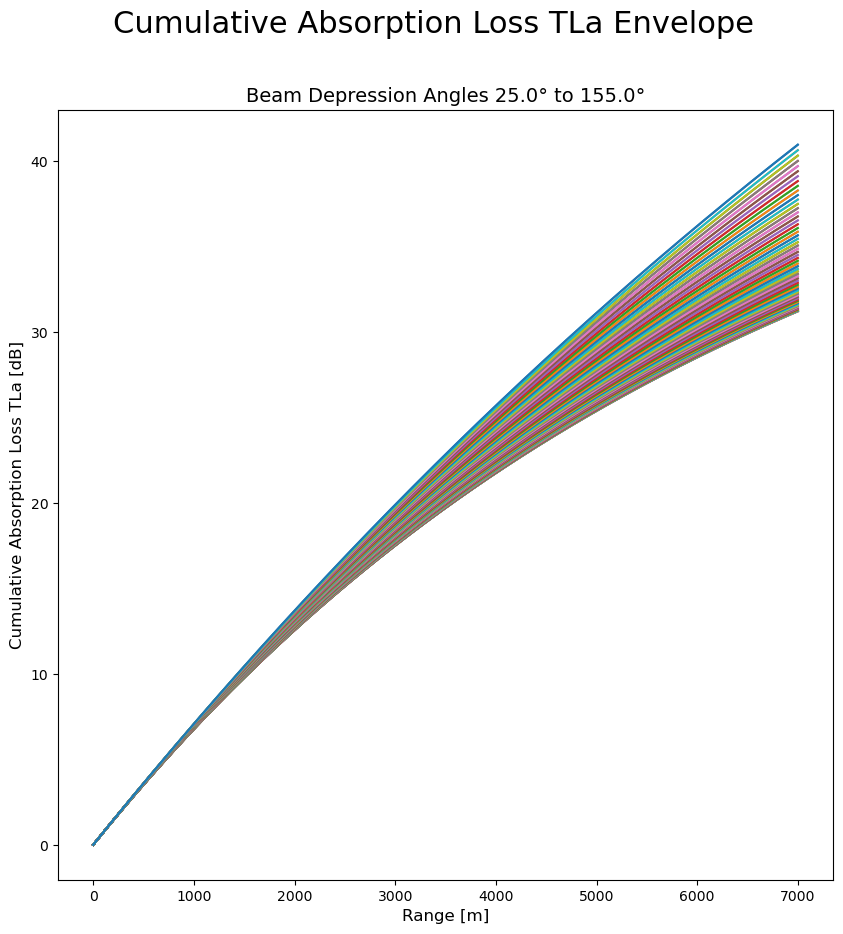

In [51]:
# C3.0 Visualizing as Graph Line on A Beam Basis

fig = plt.figure(figsize=(10, 10))

# Show the figure title and a plot title
fig.suptitle("Cumulative Absorption Loss TLa Envelope", fontsize = 22)
plt.title('Beam Depression Angles %.1f\u00B0 to %.1f\u00B0' %(th[0]*180/pi,th[-1]*180/pi), fontsize = 14)
plt.plot(TLa[:n_r,:])#,'DisplayName','TLa')

# Plot the labels

plt.xlabel('Range [m]',fontsize = 12)
plt.ylabel('Cumulative Absorption Loss TLa [dB]',fontsize = 12)

plt.show()   


***
### C3.1 Visualizing Range and Angle Dependent Data Using a Polar Mapping

The visualization provided by the code cell above is less than satisfying for almost any purpose - it is difficult to interpret the results; we are expected to identify one of the many beams in the plot and trace the results. The sheer quantity of the beams means that it is nigh-on impossible to identify them. We could try to label the beams, but that would lead to many labels in the plot, making it even harder to read.

Perhaps more important for this data is that the visualization above altogether lacks the geometry that is associated to the beams (shallow depression angle vs. great depression angle), which drives the differences between the absorption parameters for the beams. 

What can we do? There is a very simple visualization scheme that leads to a more understandable visualization. The data in the matrix `TLa` are given in a polar coordinate system, each beam originates in the same point, namely the transducer. The range is the distance from the transducer; thus, it is possible to map the data to a polar reference frame and represent data by using a color to represent its value in each point. 

The image may then be made by creating a matrix that is twice as wide (plus one) as high. Each matrix element then represents an image pixel. If we locate the transducer in the pixel in the middle of the top row it is possible to calculate the depression angle and range for each pixel in the image. For all the depression angles and ranges contained in our definition of the swath we may then simply look up what the associated value (in this case absorption) is.

The exercise coding of such a data visualization scheme would have little to do with the purpose of this lab. Therefore, you are given the `om_mapclass` that can handle this for you. This is a rather inefficient method; it can be done much faster! I have given you easy to understand, but very inefficient, code.  

The `y_max` parameter determines the resolution of the final image, a value of 300 will lead to visually attractive results, but you can play around with it e.g., start with 3 - you will see that by about 18 the visualization contains enough resolvable information to, for the purpose here, start drawing conclusions with confidence (Note that if you make the number too large you will end up trying to allocate more memory than you have available and thus cause the kernel to crash). 

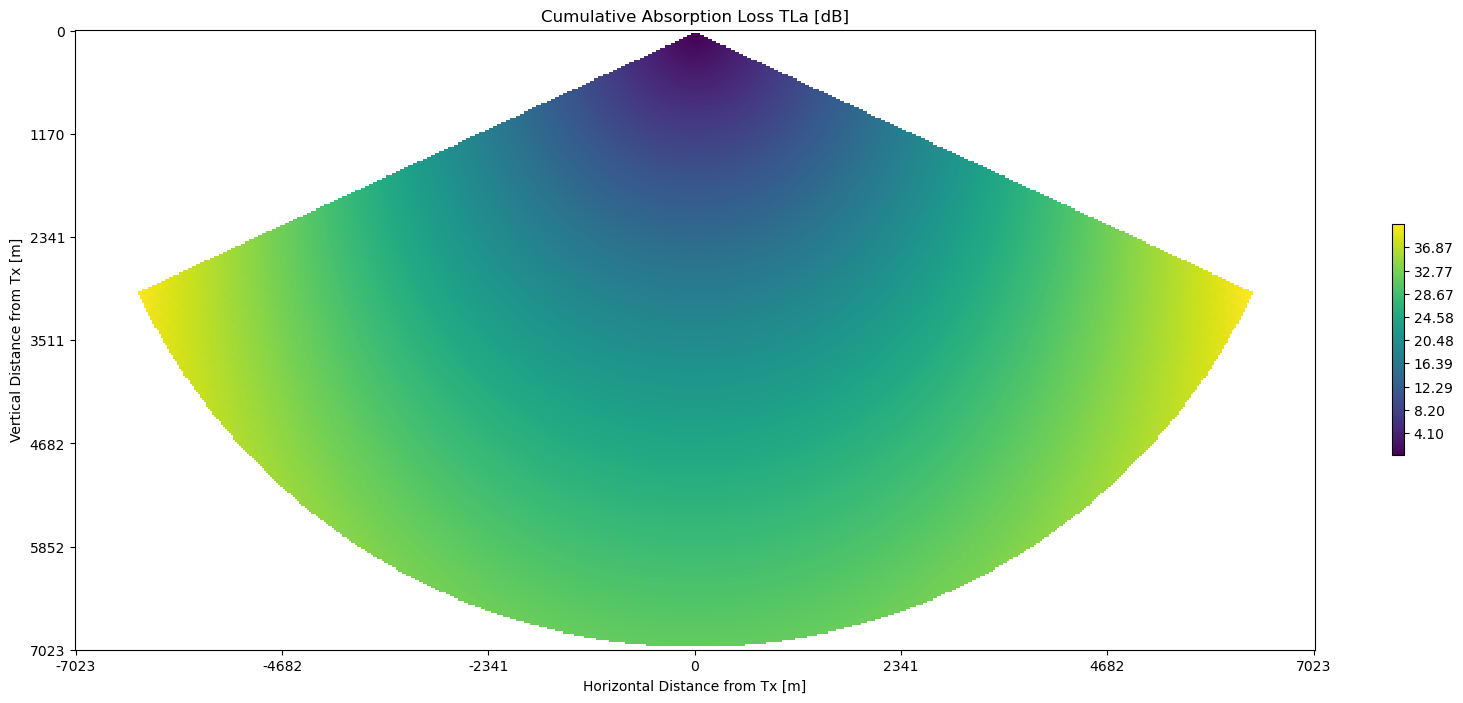

In [56]:
## 10 Create an image and mapping transform for a wedge plot
# im, X, Y, row, col = map_wedge(th,r[:n_r],y_max)
wedge = om_map()
y_max = 300
wedge.map_wedge(th,r,y_max)

## 11 Plot a Wedge plot of the data
wedge.plot(TLa[:n_r,:],'Cumulative Absorption Loss TLa [dB]','1')
plt.show()

Worked Example:

<img align="center" width="70%" style="padding-right:10px;" src="./Images/tla.png">

From the plot above it is easy to see that the cumulative absorption loss is both a function of radial distance and depth. You may ask yourself why the `TLa` is greatest for the combination of the shallowest depression angles and the greatest radial distances; from the previous line plot it would have not been so obvious that these are the locations where the greatest cumulative absorption is found. 

This plot also may, or may not, confirm your understanding from the equations of where the greatest absorption losses occur. If it does, not then re-evaluating the equations while looking at this plot hopefully will help deepening your understanding. Still, it may be even more helpful to represent the absorption dependence on variables, which we will do in the next paragraph. 

***
### C3.2 Visualizing the Ainslie & McColm (1998) Model

Understanding the behavior of a set of multivariate equations that define a model is often difficult. We often make use of graphs to visualize what a model is telling us, as you have hopefully seen in Math, Physics, and other topics that you may have studied. Off-course you still must choose the appropriate graphs. In the code cell below, we are generating three plots that each seek to illustrate some aspects of the Ainslie & McColm (1998) model.

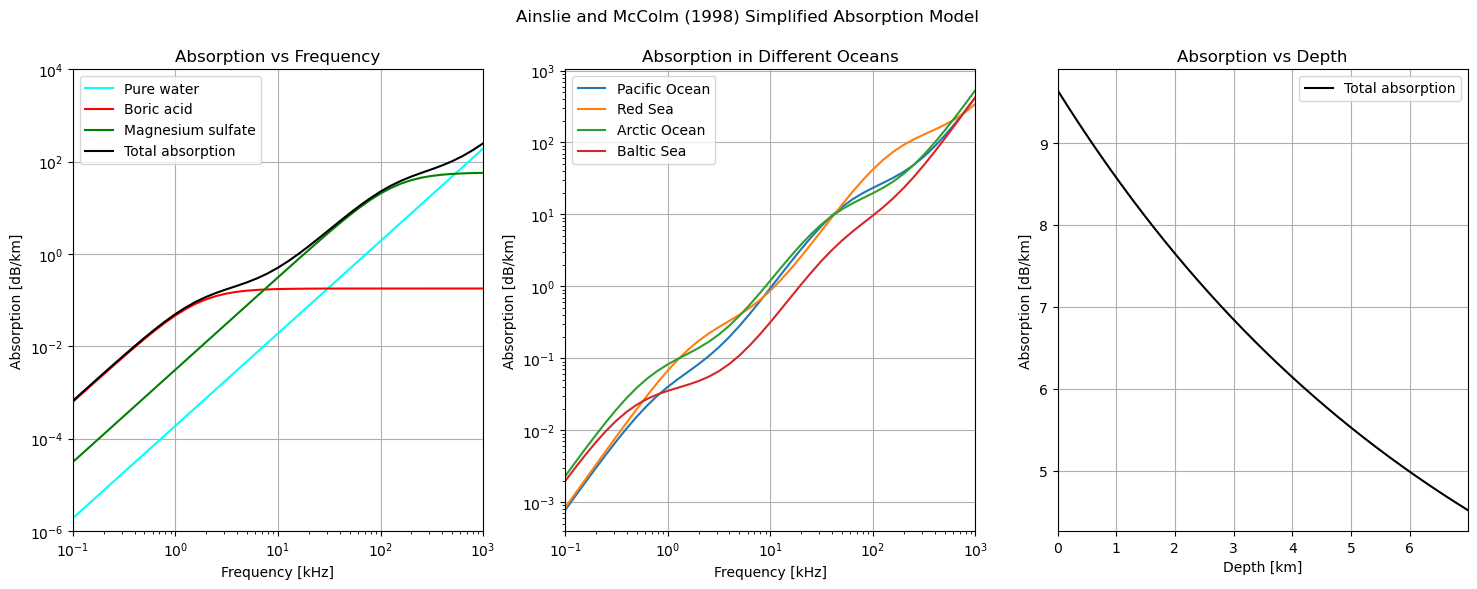

In [65]:
absorption_draw(verbose = False)
plt.show()

Worked Example:

<img align="center" width="70%" style="padding-right:10px;" src="./Images/ainslie-mccolm.png">

___
## C4 Calculate the range of Ambient <ins>N</ins>oise <ins>L</ins>evels (NL) 

For the calculation of the ambient <ins>N</ins>oise <ins>L</ins>evel use the [handout](./References/Underwater_Acoustics_and_Sonar_SP411_Handouts_and_Notes_Fall_2006.pdf) compiled by E.J. Tucholsky of the US Naval Academy Physics Department. When reading the reference, you will see that there are many causes of ambient background noise. This includes, among others: the movement of water due to tides, seismic activity, turbulence, ship traffic, and sea state. Also significant, but much harder to quantify, are transient noises that include, among others: human industrial noise, biological noise and, weather. 

In this section we will follow the nodes to create the function `noise_level` for estimating background noise

___
## C4.0 Noise Levels 10-100Hz:  NL<sub>100</sub>

The [handout](./References/Underwater_Acoustics_and_Sonar_SP411_Handouts_and_Notes_Fall_2006.pdf) follows the classic book *Ambient Noise in the Sea* 2nd edition by Robert J. Urick (1986)" in predicting the shipping noise in the frequency band 10-100 Hz to be in the range of 60-90 dB primarily dependent on shipping density and industrial activities. This noise level is nearly frequency independent in this band and identified as NL<sub>100</sub>

For convenience we will use a scale of 7 levels of shipping and associated noise level NL<sub>100</sub>:

$$\mathit{NL}_{100} = 60 + (SD - 1)\cdot5 \text{ re } 1\mu \text{Pa}$$

where:<br>
$SD$ = Shipping density with the following levels<br>
1. 60dB No shipping<br>
2. 65dB Very light shipping<br>
3. 70dB Light shipping<br>
4. 75dB Moderate Shipping<br>
5. 80dB Moderate to heavy Shipping<br>
6. 85dB Heavy Shipping<br>
7. 90dB Very heavy Shipping<br>

In the `noise_level` function contained in `noise_level.py` raise a meaningful error if the shipping density SD represented by variable `s_d` is out of range $[1,7]$; also, set the value of `nl_100` representing NL<sub>100</sub> in dB according to the equation above

In [68]:
_ = noise_level(3,1,1200,2,True)

NL_100                               : 60.0 dB re. 1 uPa


    NL_100                               : 60.0 dB re. 1 uPa
    NL_1K                                : 64.5 dB re. 1 uPa
    Lower cutoff frequency               : 0.0 Hz
    Upper cutoff frequency               : 0.0 Hz
    Average Shipping noise (Urick,1986)  : 0.0 dB re. 1 uPa
    Average Surface noise (Knudsen, 1984): 0.0 dB re. 1 uPa
    Total Ambient noise                  : 0 dB re. 1 uPa

___
## C4.2 Noise Level 1000Hz:  NL<sub>1K</sub>


The [handout](./References/Underwater_Acoustics_and_Sonar_SP411_Handouts_and_Notes_Fall_2006.pdf) also follows *Urick (1986)* in predicting the surface agitation noise level NL<sub>1K</sub> at 1 kHz

<img align="center" width="70%" style="padding-right:10px;" src="./Images/tl_1k.png">

In your code implement this table using the variables `s_s` for sea state and `nl_1k` for  NL<sub>1K</sub> and verify the results against the table above:


    if s_s==0:
        nl_1k=44.5
    elif s_s<=...
    
    ...
    
    elif s_s<=5:
        nl_1k=68.5
    else:
        nl_1k=70


In [79]:
_ = noise_level(3,1,1200,2,True)

(2,)
NL_100                               : 60.0 dB re. 1 uPa
NL_1K                                : 64.5 dB re. 1 uPa


Worked Example 1:

    NL_100                               : 90.0 dB re. 1 uPa
    NL_1K                                : 44.5 dB re. 1 uPa
    Lower cutoff frequency               : 0.0 Hz
    Upper cutoff frequency               : 0.0 Hz
    Average Shipping noise (Urick,1986)  : 0.0 dB re. 1 uPa
    Average Surface noise (Knudsen, 1984): 0.0 dB re. 1 uPa
    Total Ambient noise                  : 0 dB re. 1 uPa

Worked Example 2:

    NL_100                               : 90.0 dB re. 1 uPa
    NL_1K                                : 66.5 dB re. 1 uPa
    Lower cutoff frequency               : 0.0 Hz
    Upper cutoff frequency               : 0.0 Hz
    Average Shipping noise (Urick,1986)  : 0.0 dB re. 1 uPa
    Average Surface noise (Knudsen, 1984): 0.0 dB re. 1 uPa
    Total Ambient noise                  : 0 dB re. 1 uPa

Worked Example 3:

    NL_100                               : 90.0 dB re. 1 uPa
    NL_1K                                : 70.0 dB re. 1 uPa
    Lower cutoff frequency               : 0.0 Hz
    Upper cutoff frequency               : 0.0 Hz
    Average Shipping noise (Urick,1986)  : 0.0 dB re. 1 uPa
    Average Surface noise (Knudsen, 1984): 0.0 dB re. 1 uPa
    Total Ambient noise                  : 0 dB re. 1 uPa


___
## C4.3 Calculating the Shipping Noise Level NL<sub>Shipping</sub> and Sea Surface Agitation Level NL<sub>ss</sub>


The [handout](./References/Underwater_Acoustics_and_Sonar_SP411_Handouts_and_Notes_Fall_2006.pdf) also follows *Urick (1986)* in predicting the shipping noise level NL<sub>1K</sub> as a function of frequency.

$$\mathit{NL}_\text{shipping} = \mathit{NL}_{100} - 20\log_{10}\left(\frac{f}{100}\right)$$

And follows *Knudsen (1984)* In determining the sea surface agitation NL<sub>ss</sub>. NL<sub>ss</sub> is the dominant factor from 1 kHz unless marine mammals or rain are present.

$$\mathit{NL}_\text{surf} = \left\{\begin{matrix} \mathit{NL}_\text{1K} && f \leq 1000Hz\\  \mathit{NL}_\text{1K} - 17\log_{10}\left(\frac{f}{1000}\right)&& f \gt 1000Hz\end{matrix}\right\}$$



Note that the equations for $\mathit{NL}_\text{shipping}$ and $\mathit{NL}_\text{surf}$ are dependent on the signal frequency $f$. We are not emitting a pure tone, but rather a range of frequencies that may be characterized by the central frequency and bandwidth. Bandwidth is determined in a very similar manner to beamwidth:
<br><br>
<img align="center" width="70%" style="padding-right:10px;" src="./Images/band_beam_width.png">

We may specify the bandwidths and beamwidths in several ways. However, in echo sounding the -3 dB drop off point from a maximum response is commonly used as a criterion. The definition is in essence parallel: bandwidth is defined at the hand of the power spectral density of a signal; beamwidth is defined at the hand of the directivity pattern.

Thus, the definition of bandwidth and beamwidth is similar, but in different reference frames. They are defined as the distance between the nearest frequencies/angles  spanning the central frequency/angle where the power level is equal or more than half the power at the central frequency/angle.

___
## C4.4 Calculating the Electro Thermal Noise


The [handout](./References/Underwater_Acoustics_and_Sonar_SP411_Handouts_and_Notes_Fall_2006.pdf) indicates that beyond 100 kHz NL is dominated by electronic thermal noise which is approximated by:

$$\mathit{NL}_\text{TH}=-74+20\log_{10}f$$


___
## C4.5 Calculating the Lower and Upper Cut-Off Frequency of the Band


The [handout](./References/Underwater_Acoustics_and_Sonar_SP411_Handouts_and_Notes_Fall_2006.pdf) takes into account the bandwidth $\mathit{BW}$ of a signal, but usually no full power spectral density information of the signal is available. In our case we are only given a bandwidth. 

To be able to determine the noise at either end of the signal's spectrum, and thereby the mean noise level, we need to determine the cutoff frequencies. What is important to realize is that the specification of bandwidth is somewhat arbitrary (as is the definition for beamwidth). In the equations used here the noise is generally represented using a logarithmic frequency scale and, we generally assume that the bandwidth is centered on $f_c$ as the arithmetic mean  in this space, which corresponds to the geometric mean in linear space. 

$$\frac{\log_{10}(f_1) + \log_{10}{(f_2)}}{2} = \frac{\log_{10}(f_1\cdot f_2)}{2} = \log_{10}(\sqrt{f_1\cdot f_2})$$

$\frac{a+b}{2}$: Arithmetic mean of $a$ and $b$<br><br>
$\sqrt{a\cdot b}$: Geometric mean of $a$ and $b$<br>

From the equation above we can see that the arithmetic center frequency in a logarithmic frequency scale corresponds to the geometric mean in non-logarithmic scale.

Because we are using a logarithmic frequency scale for the determination of the noise, we should create a band centered around the geometric mean of $f_1$ and $f_2$

$$\left\{\begin{matrix} f_c = \sqrt{f_1\cdot f_2}\\ f_2 = f_1 + \mathit{BW} \end{matrix}\right\}$$<br>

Combining the two leads to:

$$f_c = \sqrt{f_1\cdot (f_1 + \mathit{BW})}$$<br>

Which may be written as:

$$f_1 = \frac{\sqrt{4f_c^2+\mathit{BW}^2} -\mathit{BW}}{2}$$

You may derive this last step easily using what you learned about squaring sums in math.

Note that the smaller the bandwidth is relative to the central frequency, the closer the arithmetic- and geometric-means become; also, even for very large bandwidths the lower frequency using the geometric mean definition is always a positive number e.g., for an $f_c$ of 100Hz and a bandwidth of 1000Hz the lower cutoff $f_1$ is calculated as 9.9 Hz.

In the `noise_level` function, create a one-dimensional `numpy` array of length 2 to hold the lower cutoff frequency $f_1$ in `f[0]`, and the upper cutoff $f_2$ in `f[1]`. Initialize the array with zero values

    f = np.zeros(2)
    
Then determine the lower cutoff `f[0]` using the above equation for $f_1$, considering the bandwidth $\mathit{BW}$ represented by `bw_rx`. 

    f[0] = ...
        
Finally, determine the upper cutoff $f_s$ using `f[0]` and `bw_rx` and assign it to  `f[1]`:

    f[1] = ...



___
## C4.6 Calculating the Noise for the Lower-  and Upper-Cutoff Frequencies $f_1$ and $f_2$

The [handout](./References/Underwater_Acoustics_and_Sonar_SP411_Handouts_and_Notes_Fall_2006.pdf) evaluates the noise level for both the lower and upper cutoff frequencies in dB, and then sums them together. We will follow this approach here as well. The text discusses the noise in four distinct cases depending on the frequency being analyzed, namely the <10<sup>1</sup>,10<sup>2</sup>> Hz, [10<sup>2</sup>,10<sup>3</sup>> Hz, [10<sup>3</sup>,10<sup>5</sup>> Hz and, >10<sup>5</sup> Hz bands. However, confusingly, this is not how the numbers are determined in the paper. Below you will find how to calculate the $\mathit{NL}_\text{ship}$ and $\mathit{NL}_\text{surf}$ components:

    for i in range(2):
        if f[i] < 10**1:
            raise RuntimeError('NL: function not implemented for frequencies < 10 Hz')

        elif 10**1 <= f[i] and f[i] < 10**2:
            nl_ship[i] = nl_100
            nl_surf[i] = nl_1k
        elif 10**2 <= f[i] and f[i] < 10**3:
            nl_ship[i]=nl_100 - 20 * log10(f[i] / 10**2)
            nl_surf[i] = nl_1k
        elif 10**3 <= f[i] and f[i] < 10**5:
            nl_ship[i]=nl_100 - 20 * log10(f[i] / 10**2)            
            nl_surf[i] = nl_1k-17 * log10(f[i] / 10**3)
        else:
            raise RuntimeError('NL: function not implemented for frequencies > 100 kHz')
    

___
## C4.7 Determining the Levels for the Entire Signal

having followed the [handout](./References/Underwater_Acoustics_and_Sonar_SP411_Handouts_and_Notes_Fall_2006.pdf) We now have estimates of the various noise levels for the cutoff frequencies. To determine the noise level of each for the entire bandwidth we will take the average of the levels at the cutoffs and multiply it by the bandwidth - which in logarithmic scale is adding a bandwidth term i.e.,

$$\mathit{NL}_\text{cause} = \frac{\mathit{NL}_{\text{cause,}f_1}+\mathit{NL}_{\text{cause,}f_2}}{2}+10\log\Delta f$$

In our case we want to determine the total noise levels from the surface `nl_surf_band` and shipping `nl_ship_band`:

    nl_surf_band = sum(nl_surf)/2+10*log10(bw_rx)
    nl_ship_band = ...

In [81]:
_ = noise_level(3,4,200,100,True)

NL_100                               : 75.0 dB re. 1 uPa
NL_1K                                : 64.5 dB re. 1 uPa
Lower cutoff frequency               : 156.15528128088303 Hz
Upper cutoff frequency               : 256.15528128088306 Hz
Shipping noise (Urick,1986)          : 89.0 dB re. 1 uPa
Surface noise (Knudsen, 1984)        : 84.5 dB re. 1 uPa


Worked Example:

    NL_100                               : 75.0 dB re. 1 uPa
    NL_1K                                : 64.5 dB re. 1 uPa
    Lower cutoff frequency               : 156.15528128088303 Hz
    Upper cutoff frequency               : 256.15528128088306 Hz
    Shipping noise (Urick,1986)          : 89.0 dB re. 1 uPa
    Surface noise (Knudsen, 1984)        : 84.5 dB re. 1 uPa
    Total Ambient noise                  : 0 dB re. 1 uPa

___
## C4.8  Adding Incoherent Sound Levels

Generally sound sources have different phases and frequencies, making them **incoherent**. Since the background noise is random in nature, we will consider the different sources incoherent. Adding incoherent sound (or voltage) levels is achieved through:

$$L_{\text{incoherent sum}} = 10\cdot\log_{10}\sum_{i = 1}^n10^{{L_i}/{10}}$$

where:<br>
$L_i$: Sound Pressure Level due to source $i$, incoherent to all other sources<br>
$L_{\text{incoherent sum}}$: Combined sound pressure level due to incoherent sources $L_i$<br> 

in our case the levels are determined by the mean noise levels from $f_1$ and $f_2$ plus a bandwidth term to capture the total contributions from the interval $[f_1,f_2]$ - we already calculated these as `nl_surf_band` and `nl_ship_band`

The model predicts that if we combine two incoherent signals of equal magnitude the total level increases by 3dB. Note that in the handout this is referred to as the *level sum* and indicated by the operator $\oplus$, which are both uncommon usages.

In the file `om_math.py` add the function `incoherent_sum()` that takes as its argument an `iterable` of incoherent sound pressure levels `spl`.

    def incoherent_sum_log10(...):


___
## C4.8.0  Determine the Number of SPLs

The first thing to do is to determine the number of sound levels passed in in the argument `spl` and assign it to the variable `num_levels`

    num_levels = len(spl)

___
## C4.8.1  Check to see whether  `spl` is Iterable

if `num_levels` is smaller than 2 there is either zero or one arguments i.e., `spl` is not iterable. No matter, the sum is trivial in this case, namely the value of `spl` itself, so just return it

    if num_levels ... :
        return ...

___
## C4.8.2  Initialize the Incoherent Sum

We will iterate over the various SPLs included in `spl`, summing its incoherent contribution to the total. This means that we need to initialize the total `sum_incoherent` as zero.

    sum_incoherent = ...

___
## C4.8.3  Iterate Through the List

Now that we have the right conditions iterate through the list, building up the sum

$$\text{sum_incoherent} = \sum_{i = 1}^n10^{{L_i}/{10}}$$

    for l in spl:
        sum_incoherent += ...
        
Make sure to put parentheses in the appropriate location! You will need one pair of parentheses. Always keep PEMDAS in mind (**PEMDAS**: <ins>P</ins>arenthesis, <ins>E</ins>xponents, <ins>M</ins>ultiplication, <ins>D</ins>ivision, <ins>A</ins>ddition, <ins>S</ins>ubtraction).

Note: the use of parentheses is one of the things beginning programmers struggle the most with. It is generally a good idea to only use them where they are really needed. Otherwise you may quickly end up with an overwhelming amount of parentheses that make debugging hard to achieve.

___
## C4.8.3  Map it Back to Decibels

We now have the sum, but we want it in decibels i.e. we need to return ${10}\log_{10}(\text{sum_incoherent})$

    return 10 * ...

In [114]:
spl = (89,87)
for l in spl:
    print(l)
sum_incoherent = 0    
sum_incoherent += 10 ** (spl[1]/10)
10 * np.log(sum_incoherent)

89
87


200.32490309048197

In [119]:
print( "The combination of two incoherent signals with SPL 87 and 89: %.1f dB"%incoherent_sum_log10((89,87)))
print( "The combination of two incoherent signals with SPL 0 and 89: %.1f dB"%incoherent_sum_log10((0,87)))
print( "The combination of two incoherent signals with SPL 10 and 10: %.1f dB"%incoherent_sum_log10((10,10)))
print( "The combination of two incoherent signals with SPL 90 and 90: %.1f dB"%incoherent_sum_log10((90,90)))
print( "The combination of two incoherent signals with SPL 90 and 96: %.1f dB"%incoherent_sum_log10((90,96)))

The combination of two incoherent signals with SPL 87 and 89: 91.1 dB
The combination of two incoherent signals with SPL 0 and 89: 87.0 dB
The combination of two incoherent signals with SPL 10 and 10: 13.0 dB
The combination of two incoherent signals with SPL 90 and 90: 93.0 dB
The combination of two incoherent signals with SPL 90 and 96: 97.0 dB


Worked Example:

    The combination of two incoherent signals with SPL 87 and 89: 91.1 dB
    The combination of two incoherent signals with SPL 0 and 89: 87.0 dB
    The combination of two incoherent signals with SPL 10 and 10: 13.0 dB
    The combination of two incoherent signals with SPL 90 and 90: 93.0 dB
    The combination of two incoherent signals with SPL 90 and 96: 97.0 dB

Note that the louder of the two signals will dominate the outcome. For example, if music is at a level just above your normal voice level you have to raise your voice only just a bit to make yourself heard.

___
## C4.9 Determine the Total Noise Level

The last thing to do is to combine the incoherent shipping and sea surface noise levels and assign the value to the variable `NL`. We will use the `incoherent_sum_log10` function that we generated for this purpose. As you know the incoherent source levels need to be supplied as an `iterable`. In our case let's use a tuple (in cases such as this it often is safest to use `tuples`, as a function cannot change the values in a tuple). In the code cell associated to C4.8.3 you see an example of how to pass values as a tuple

    nl = incoherent_sum_log10(...)



In [121]:
print(bw_rx)
print(f_c)
NL = noise_level(s_s, s_d, f_c, bw_rx,True)

2000
30000
NL_100                               : 85.0 dB re. 1 uPa
NL_1K                                : 66.5 dB re. 1 uPa
Lower cutoff frequency               : 29016.66203960727 Hz
Upper cutoff frequency               : 31016.66203960727 Hz
Shipping noise (Urick,1986)          : 68.5 dB re. 1 uPa
Surface noise (Knudsen, 1984)        : 74.4 dB re. 1 uPa
Total Ambient noise                  : 75.38633327485005 dB re. 1 uPa


Worked Example:

    2000
    30000
    68.46787486224656
    NL_100                               : 85.0 dB re. 1 uPa
    NL_1K                                : 66.5 dB re. 1 uPa
    Lower cutoff frequency               : 29016.66203960727 Hz
    Upper cutoff frequency               : 31016.66203960727 Hz
    Shipping noise (Urick,1986)          : 68.5 dB re. 1 uPa
    Surface noise (Knudsen, 1984)        : 74.4 dB re. 1 uPa
    Total Ambient noise                  : 75.38633327485005 dB re. 1 uPa


***
## C5 Get the backscatter Angular Response curve BS

<img align="left" width="80%" style="padding-right:10px;" src="./Images/backscatter_curve.png">

    Note that we use depression angles, whereas in the examples incidence angles are shown!!
    
For this lab, you need to have an estimate of the seabed backscatter angular response curve. Typically, most companies pick three seabed types (“mud, sand, gravel)”. As we know from the environmental lecture, the shape of these angular response curves has typical characteristics.

For most grazing angles, mud is weaker than sand which is weaker than gravel. For all three, for grazing angle below ~ 70 (above 20 incidence) the backscatter intensity rolls off non-linearly. A common model for this is Lambertian scattering.

Within 10-20 degrees of normal incidence, however, most seafloors show enhanced scattering that departs from the Lambertian model. The smoother seafloor sediment types (typically the finer grained, lower impedance), tend to exhibit a pronounced specular peak; generally speaking larger peaks have narrower ranges of angles away from normal incidence.

The simplified model above is suggested as a way of creating a typical angular response. You may use this, or if you prefer another way, go ahead, as long as you explain what you are doing.    
    
In the code cell below determine the backscatter and assign it to the variable `BS`

***
## C5.0 Create the Function `modified_lambertian`

We will implement the simplified model in the `modified_lambertian()` function located in the file `modified_lambertian.py`. The arguments that the function will take are: `th` for an iterable set of depression angles, `s_b` the list of bottom properties generated in step C0, and `verbose` a flag which, when set to `True`, will cause the function to create some plots of the estimated bottom strength BS.

The function will return the bottom strength BS as defined by the variable `BS` - at this point we will initialize it to zero.

    def modified_lambertian( ... ):
        BS = ...
        n_bot=len(s_b[0])
        
`n_bot` is the number of bottom types passed in in the list s_b

In [132]:
BS=modified_lambertian(th,s_b,False)
print(BS)

0


 Worked Example:
 
     0

***
## C5.1 Convert the Depression Angles to Incidence Angles

I prefer to use depression angles, but unfortunately many in the literature mix coordinate systems - we will follow suit... Also, we will create three copies in a `numpy` array so that we may avoid the use of a for loop later:

    th=np.tile(pi/2-th,(n_bot,1)).

The above line of code achieves two things:

1. It maps the depression angle to incidence angle through $\pi/2 - \theta_i$
2. It creates a matrix of `n_bot` rows each holding all the $\theta_i$

To give you a better feeling for the `tile` function inspect the code cell below

In [125]:
a = np.asarray([1,2,3])
print('The input array: ', str(a))
print('\nAn example of tiling: \n', str(np.tile(a,(3,1))))
print('\nAnother example of tiling: \n', str(np.tile(a,(1,3))))

The input array:  [ 1.00000000  2.00000000  3.00000000]

An example of tiling: 
 [[ 1.00000000  2.00000000  3.00000000]
 [ 1.00000000  2.00000000  3.00000000]
 [ 1.00000000  2.00000000  3.00000000]]

Another example of tiling: 
 [[ 1.00000000  2.00000000  3.00000000  1.00000000  2.00000000  3.00000000
   1.00000000  2.00000000  3.00000000]]


***
## C5.2 Determine the Lambertian Component

Next, we will determine the Lambertian scattering component, which we will store in the variable `bs_lambertian`. It is given by:

$$\mathit{BS}_\text{Lambertian}(\theta) = \mathit{BS}(0)+10\log_{10}\left(\cos^2\theta\right)$$

We will do this in two steps - first we convert the roughness parameters to a column vector from the one-dimensional array that they were passed in as

    rough = s_b[1].reshape(n_bot,1)
    
Then we determine the backscatter level $\mathit{BS}_\text{Lambertian}(\theta)$ according to the formula above

    bs_lambertian = rough + 10 * log10(cos(th)**2)
    
Understanding how to work with `numpy` arrays can lead to very simple to read code! The result of the single line of code above is that we now have $\mathit{BS}$ values for **all** angles of incidence for **each** bottom type. Often such a problem would be solved in a nested for loop such as:
 
     for t in th:
         for b in s_b[1]:
             ...
             
The result of omitting the `for` loop is code that is not only much easier to read, but it also executes up to orders of magnitude faster. (Note that this is not true for all programming languages, but it is for Python, and other interpreted languages). 

***
## C5.3 Determine the Specular Component

Next, we determine the Specular scattering component. We will store this in the variable `bs_lambertian`. It is given by:

$$\Delta\mathit{BS}_\text{specular}(\theta) = \frac{\Delta\mathit{BS}(0)\cdot\left(1+\cos\left(\frac{\pi\theta}{\mathit{CA}}\right)\right)}{2}$$

We do this in two steps again - first we convert the specular strength $\Delta\mathit{BS}$ stored in `s_b[2]` and critical angle $\mathit{CA}$ to column vectors from the one dimensional arrays that they currently are:

    spec = ... .reshape(...)
    crit = ...
    
Then we determine the backscatter level according to the formula above:

    bs_specular = spec * (1 + cos( pi * (th / crit))) / 2
    
Determine the range of incidence angles `r_CA` for which $\left|\theta\right|>=\mathit{CA}$:

    r_CA=abs(...)>=crit
    
This results in a Boolean array that we may use for setting all the values outside $\mathit{CA}$ to zero:

    bs_specular[...]=0


***
## C5.4 Total Backscatter Angular Response 

Finally, we determine the total bacskscatter response curve for all bottom types; it is simply the sum of the Lambertian- and specular angular response curves

$$\Delta\mathit{BS}{\theta} = \Delta\mathit{BS}_\text{Lambertian}(\theta) + \Delta\mathit{BS}_\text{specular}(\theta) $$

Assign the values $\Delta\mathit{BS}{\theta}$ to variable `bs`

    bs=...+...


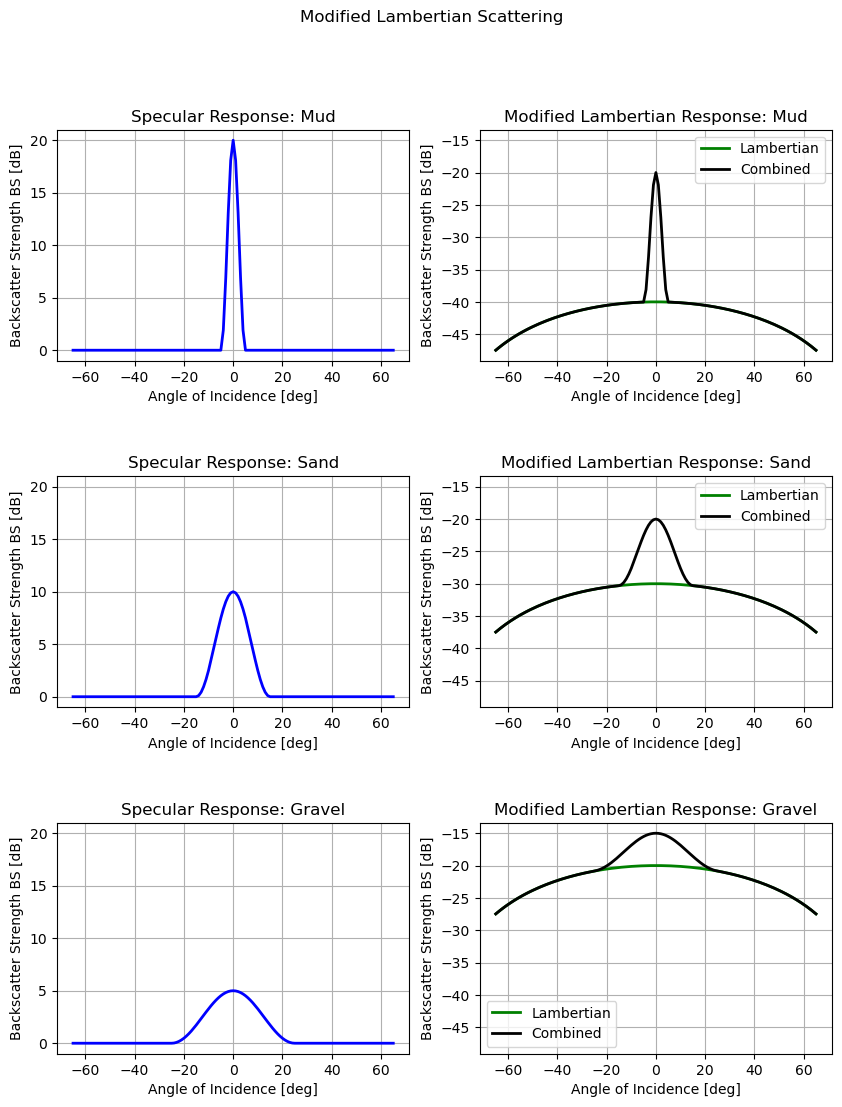

In [149]:
BS=modified_lambertian(th,s_b,verbose)


Worked Example:

<img align="center" width="40%" style="padding-right:10px;" src="./Images/bs.png">

## C.6 Calculate the Ensonified Area EA

Assume each beam reaches the seafloor at the range defined by the detection threshold and that the seafloor is flat in that location (this is physically impossible, but we will run with it, we have to assume something). 

### Evolution of the projected beam pattern product with obliquity

The assumption from above mean that as the incidence angle grows, so the slant range grows. Also, the receiver beam width grows due to increased steering. All these effects conspire to lengthen the across-track dimension of the projected beam footprint.

Inversely, as the incidence angle grows, the radial dimension of the projected pulse length shortens. Thus, there is a transition in the controlling factor on the across-track dimension of the instantaneously ensonified area from:

    •Beamwidth limited -near nadir, where the projected pulse length (dx) is greater than the across track projected beam footprint
    •Pulselength limited –away from nadir where the projected pulse length is now smaller than the across track beam footprint.


<img align="left" width="80%" style="padding-right:10px;" src="./Images/EA.png">

As Urick recognized, over half a century ago, the total backscattered intensity is related to the instantaneously ensonified area. This is related to the angular and range resolution of the sonar used.

This shows the simplified geometry that you might use to estimate the Instantaneously Ensonified Area parameter that is part of the in the Bottom Target Strength term in the Sonar Equation.

While the real footprint is either a projection of an elliptical beam, or the truncation of an annulus, the simplified geometry used here is commonly applied in most backscatter post-processing software.

Beamwidth limited Area:   

$$A_{bl}=R^2\cdot \phi_X \cdot \frac{\phi_Y}{sin\theta}$$

Where:<br>
$A_{bl}$: Beamwidth limited area<br>
$R$: Range<br>
$\phi_X$: Beam with in along-track direction<br>
$\phi_Y$: Beam with in across-track direction<br> 

Pulse Width limited Area: 

$$A_{pl}= \frac{PW_m}{|cos\theta|}\cdot R \cdot \phi_X$$

Where:<br>
$A_{pl}$: Pulse width limited area<br>
$PW_m$: Pulse width in m<br>

Thus crossover $R_c$ at:

$$A_{bl}=A_{pl} \Rightarrow $$

$$R_c=PW_m \cdot \frac{sin\theta}{\phi_Y\cdot|cos\theta|}$$
<br><br>
Feel free to use a geometry like this. If you wish to try another equation, that is fine also but your answers will not match what is shown here (it should be very close though).




***
## C6.1 Calculate Pulse Width in m

In step C0 you defined the pulse width $PW_c$ in cycles. We need to map this to the pulse width in meters (PWm) and assign it to the variable `pw_m` 

$$PW_m = \frac{PW_c}{f_c}\cdot c$$

In [134]:
# Calculate PWm using PWc, f_c and C
pw_m=(pw_c/f_c)*c
print('Pulse Width: %.2fm'%pw_m)

Pulse Width: 1.22m


Worked Example:

    Pulse Width: 1.22m


## C6.2 Calculate the cross-over range 

Calculate the cross-over range $R_c$ and assign it to the variable `r_c` in the code cell below. Note that:

$$\lim_{x \to 0} {Rc} = \infty$$

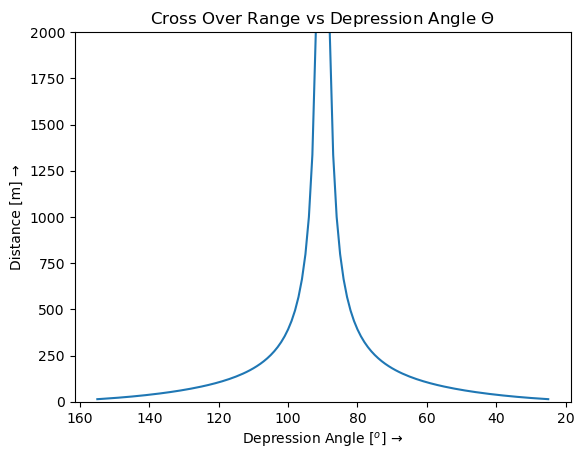

In [135]:
# Calculate cross over Range Rc, using the depression angle th, the pulse width in m PWm the beamwidth ph_y

r_c=sin(th)*pw_m/(ph_y*abs(cos(th)))
plt.plot(th*180/pi,r_c)
ax = plt.gca()
plt.title('Cross Over Range vs Depression Angle $\Theta$')
ax.invert_xaxis()
plt.ylabel('Distance [m] →')
plt.xlabel('Depression Angle $[^o]$ →')
plt.ylim((0,2000))
plt.show()

Worked Example:

<img align="center" width="30%" style="padding-right:10px;" src="./Images/cross-over.png">

## C6.3 Calculate the Ensonified Area

In the code cell below loop through all the beams and for each range determine the Ensonified Area $\mathit{EA}$, assign the outcomes to the array `EA`. `EA` should have `n_r` rows and `n_beams` columns.

Shown is how to calculate the $\mathit{EA}$ up to the cross over range, complete the calculation for beyond the cross over range


In [136]:
EA=np.zeros((n_r,n_beams))
for i in range(n_beams):

    # Calculate the beamwidth limited areas EA for all R up to Rc i.e. EA[r<=Rc[i],i], using all R up to Rc i.e.
    # EA for all ranges up to Rc for beam i:  EA[r<=Rc[i],i]
    # All ranges up to Rc:                     r[r<=Rc[i]]
    # Beamwidth in the along track:            ph_x
    # Beamwidth in the acroess track:          ph_y[i]
    # depression angle                         th[i]
    EA[r <= r_c[i],i] = ( r[r <= r_c[i]]**2) * ph_x * ph_y[i] / sin(th[i])
    
    # Calculate the pulsewidth limited areas EA for all R beyond Rc
    EA[r > r_c[i],i] = r[r > r_c[i]] * ph_x * pw_m / abs(cos( th[i]))

print(EA)

[[ 0.00001706  0.00001585  0.00001478 ...  0.00001478  0.00001585
   0.00001706]
 [ 0.00206369  0.00191803  0.00178833 ...  0.00178833  0.00191803
   0.00206369]
 [ 0.00752137  0.00699052  0.00651778 ...  0.00651778  0.00699052
   0.00752137]
 ...
 [ 164.85402893  166.23217606  167.68506862 ...  167.68506862
   166.23217606  164.85402893]
 [ 164.87758927  166.25593336  167.70903356 ...  167.70903356
   166.25593336  164.87758927]
 [ 164.90114961  166.27969065  167.73299849 ...  167.73299849
   166.27969065  164.90114961]]


Worked Example:

    [[ 0.00001706  0.00001585  0.00001478 ...  0.00001478  0.00001585
       0.00001706]
     [ 0.00206369  0.00191803  0.00178833 ...  0.00178833  0.00191803
       0.00206369]
     [ 0.00752137  0.00699052  0.00651778 ...  0.00651778  0.00699052
       0.00752137]
     ...
     [ 164.85402893  166.23217606  167.68506862 ...  167.68506862
       166.23217606  164.85402893]
     [ 164.87758927  166.25593336  167.70903356 ...  167.70903356
       166.25593336  164.87758927]
     [ 164.90114961  166.27969065  167.73299849 ...  167.73299849
       166.27969065  164.90114961]]


## C6.4 Convert to decibels for the sonar equation

$$\mathit{EA}=10\cdot log_{10}\left( EA \right) $$

In the code cell below convert `EA` to decibels.

In [137]:
EA=10*log10(EA)
print(EA)

[[ -47.68141784  -47.99929188  -48.30338795 ...  -48.30338795
   -47.99929188  -47.68141784]
 [ -26.85356413  -27.17143818  -27.47553424 ...  -27.47553424
   -27.17143818  -26.85356413]
 [ -21.23703194  -21.55490598  -21.85900205 ...  -21.85900205
   -21.55490598  -21.23703194]
 ...
 [ 22.17099566  22.20715090  22.24494393 ...  22.24494393  22.20715090
   22.17099566]
 [ 22.17161629  22.20777153  22.24556456 ...  22.24556456  22.20777153
   22.17161629]
 [ 22.17223683  22.20839208  22.24618511 ...  22.24618511  22.20839208
   22.17223683]]


Worked Example:

    [[ -47.68141784  -47.99929188  -48.30338795 ...  -48.30338795
       -47.99929188  -47.68141784]
     [ -26.85356413  -27.17143818  -27.47553424 ...  -27.47553424
       -27.17143818  -26.85356413]
     [ -21.23703194  -21.55490598  -21.85900205 ...  -21.85900205
       -21.55490598  -21.23703194]
     ...
     [ 22.17099566  22.20715090  22.24494393 ...  22.24494393  22.20715090
       22.17099566]
     [ 22.17161629  22.20777153  22.24556456 ...  22.24556456  22.20777153
       22.17161629]
     [ 22.17223683  22.20839208  22.24618511 ...  22.24618511  22.20839208
       22.17223683]]

## C6.5 Visualize the Results

We have seen before that proper visualization of the data may lead to greater insight. In this case we want to see where we may expect a greater gain due to the ensonified area. The wedge that we used previously is again a relatively intuitive way of representing the data for this purpose, but not necessarily for providing an intuitive insight of why this is so. 

What we can see quickly from this plot is that the ensonified area is a function of angle and distance, but only near nadir does it keep increasing with range. Ask yourself whether you can think of an intuitive plot that shows why we see this behavior? (You DO NOT have to provide a written answer, nor create code, but feel free to do so if you want)

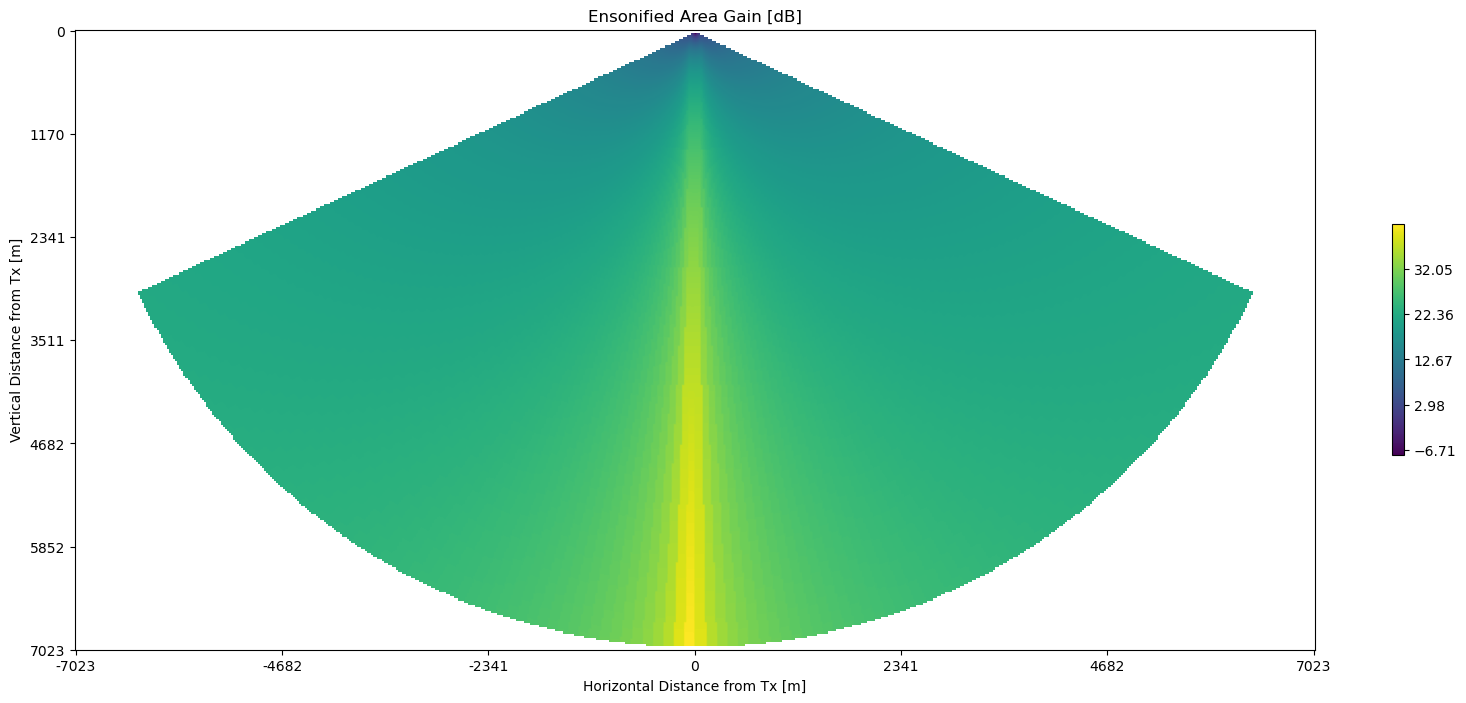

In [ ]:
wedge = om_map()
wedge.map_wedge(th,r[:n_r],y_max)
wedge.plot(EA[:n_r,:],'Ensonified Area Gain [dB]','1')


## A Word About Handling Arrays in Python

In this step we will be transposing a vector that we extract from a matrix. In `numpy`
a 1-D vector cannot be transposed as it is truly one-dimensional, and the concept of 
transposition is to swap the dimensions.

Thus, to transpose a vector it needs to be two-dimensional! This can be very confusing until
you get used to it. The popular *Matlab* and *R* numerical packages do not impose this constriction,
so if you are used to working with them this will be a big adjustment!

This can be particularly confusing if you extract a column from a matrix. For example, if
you create a 2-D matrix `A` as follows:

    A = np.asarray(range(12)).reshape((3,4))
    
If you then extract the first row `A[1,:]` the result is: `array([4, 5, 6, 7])` with shape `(4,)`. 
Its transpose `A[1,:]` is also `array([4, 5, 6, 7])` with shape `(4,)`!
    
To get a better feeling for how to deal with 2D vectors, as you would in linear algebra, study the code cell below carefully. Until you understand this you will struggle with the implementation of linear algebra in Python! 

In [142]:
A = np.asarray(range(12)).reshape((3,4))
print("The matrix A:")
print(A)
print()
print("2\u00BA row of A as a 1D vector is A[1,:]       : "+str( A[1,:]))
print("The shape of A[1,:] is                     : "+str(A[1,:].shape))
print("The shape its transpose A[1,:].T is also   : "+str(A[1,:].T.shape))
print("The contents of the transpose are          : "+str(A[1,:].T))
print()
print("To be able to transpose we need the vector to be a 2-D vector")
print("You can achieve this by using a slice (subset of the matrix)")
print()
print("2\u00BA row of A as a 2D vector is A[1:2,:]     : "+str( A[1:2,:]))
print("The shape of A[1:2,:] is                   : "+str(A[1:2,:].shape))
print("The shape its transpose A[1:2,:].T is      : "+str(A[1:2,:].T.shape))
print("The contents of the transpose are          : ")
print(str(A[1:2,:].T))
print("____")
print()
print("Columns are handled similarly:")
print("2\u00BA column of A as a 1D vector is A[:,1]    : "+str( A[:,1]))
print("The shape of A[:,1] is                     : "+str(A[:,1].shape))
print("The shape its transpose A[:,1].T is also   : "+str(A[:,1].T.shape))
print("The contents of the transpose are          : "+str(A[:,1].T))
print("2\u00BA column of A as a 2D vector is  is A[:,1:2] : ")
print(A[:,1:2])
print()
print("The shape of A[:,1:2] is                   : "+str(A[:,1:2].shape))
print("The shape its transpose A[:,1:2].T is      : "+str(A[:,1:2].T.shape))
print("The contents of the transpose are          : "+str(A[:,1:2].T))

A[slice(0,1),:]

The matrix A:
[[ 0.00000000  1.00000000  2.00000000  3.00000000]
 [ 4.00000000  5.00000000  6.00000000  7.00000000]
 [ 8.00000000  9.00000000  10.00000000  11.00000000]]

2º row of A as a 1D vector is A[1,:]       : [ 4.00000000  5.00000000  6.00000000  7.00000000]
The shape of A[1,:] is                     : (4,)
The shape its transpose A[1,:].T is also   : (4,)
The contents of the transpose are          : [ 4.00000000  5.00000000  6.00000000  7.00000000]

To be able to transpose we need the vector to be a 2-D vector
You can achieve this by using a slice (subset of the matrix)

2º row of A as a 2D vector is A[1:2,:]     : [[ 4.00000000  5.00000000  6.00000000  7.00000000]]
The shape of A[1:2,:] is                   : (1, 4)
The shape its transpose A[1:2,:].T is      : (4, 1)
The contents of the transpose are          : 
[[ 4.00000000]
 [ 5.00000000]
 [ 6.00000000]
 [ 7.00000000]]
____

Columns are handled similarly:
2º column of A as a 1D vector is A[:,1]    : [ 1.00000000  5.00000000

array([[ 0.00000000,  1.00000000,  2.00000000,  3.00000000]])

## C7 Calculate the Attainable Range

Monostatic Active SONAR Equation
$$\mathit{SNR}=\mathit{SL}-2\mathit{TL}-\mathit{NL}+\mathit{BTS}+\mathit{DI}_\text{rx}$$
$$\mathit{SNR}=\mathit{SL}-2(\mathit{TL}_\text{ss}+\mathit{TL}_\text{a})-\mathit{NL}+(\mathit{BS}+\mathit{EA})+\mathit{DI}_\text{rx}$$

 <ins>S</ins>ource    <ins>L</ins>evel  including  transmit  directivity    : SL<br>
 <ins>D</ins>irectivity   <ins>I</ins>ndex  for  the  receive  array       : DIrx<br>
 <ins>T</ins>ransmission    <ins>L</ins>oss  due  to  absorption             : TLa<br>
 <ins>T</ins>ransmission   <ins>L</ins>oss   due  to  spherical  spreading    : TLs<br>
 ambient   <ins>N</ins>oise   <ins>L</ins>evel                             : NL<br>
 bottom   <ins>B</ins>ack<ins>S</ins>catter  angular  response         : BS<br>
 bottom  <ins>E</ins>nsonified  <ins>A</ins>rea  gain                     : EA<br>


Rather than having you struggle with the implementation of this, I will supply you with the bit of code that will put it all together. However, make sure that you understand what the bit of code provided does!

In [155]:
r_max=np.zeros((n_bot,n_beams))

for i in range(n_beams):
    # Determine whether the SNR is greater than the detection threshold for
    # all beams for all ranges. This will be uniformly true until it is
    # uniformly false. The distance reached is therefore the number of
    # indices at which (SNR>DT) * resolution res of the range array R for
    # each beam i
    
    # Note that you need to use the numpy version of the sum function, as 
    # we need to define the dimension (axis) over which we need to sum
    
    # Another thing to be aware of that in numpy a 1-D vector cannot be transposed
    # as it is truly one-dimensional, thus to transpose a single row or column of 
    # a matrix we have to extract it using a slice
    
    r_max[:,i]=np.sum((np.tile(SL-2*(TLa[:,i].T+TLs)-NL+di_rx+EA[:,i].T,(n_bot,1))+BS[:,i:i+1])>d_t,1)*r_i
    
# Find the index to the max range
n_r_max=sum(r<np.max(r_max))

print('The maximum range is found at index:', str(n_r_max))



The maximum range is found at index: 2992


Worked Example:

    The maximum range is found at index: 2992


## C7.1 Visualize the Results

Finally we want to provide an easily interpretable way of visualizing the results. We could again use a wedge display, but since we have calculated the maximum attainable range for each beam in our hypothetical swath sonar system we may as well visualize the max attainable range for each one of those beams for the various bottom types. We will achieve this by creating a plot for each of the bottom types and represent the attainable range of a beam by drawing a vector in the direction of the beam with as its length a scaled version of the attainable range.

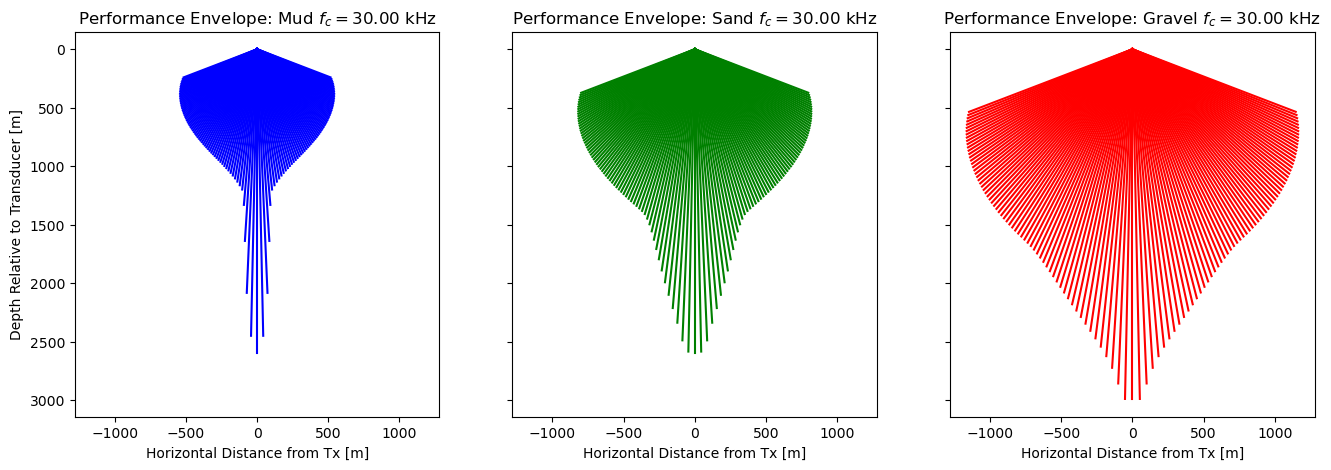

In [156]:
## 14 Plot the attainable ranges

fig, ax = plt.subplots(nrows=1,ncols=n_bot,figsize=(16, 5),sharex = True, sharey=True)

# Set a series of colors to cycle through

color = ['b','g','r','c','m','y','k']

for i in range(n_bot):

    ax[i].set_title('Performance Envelope: '+s_b[0][i]+' $f_c = $'+"%.2f kHz"%(f_c/1000))
    for j in range(n_beams):
        ax[i].plot((0,r_max[i,j]*cos(th[j])),(0,r_max[i,j]*sin(th[j])),color[i%len(color)])
        ax[i].invert_yaxis()
        ax[i].set_xlabel('Horizontal Distance from Tx [m]' )
    ax[0].set_ylabel('Depth Relative to Transducer [m]' )    
    
plt.show()
        

Essay Questions

Before you answer these questions make sure that you preserve all the values given to you in step C.0 so that you may revert back to them. ***Remember that 3 dB corresponds to a doubling in level!***

For your answers to 1-5 provide screen grabs of relevant plots to illustrate your answers

1.  Describe what happens if you change the source level SL, if you double it does the range double? 

2.  Reset SL to it's original value, comment on the effect of changing the pulse length, does doubling it double the range? 

3.  Reset the pulse length to it's original value, comment on what happens when you change the central frequency

4.  Reset the central frequency - comment on the effects of changing the bandwidth

5.  Reset the bandwidth, comment on the effect of changing the Directivity Index.

___

6. Based purely on the expected absorption coefficient where would you go test your 200 kHz multi-beam system to get the best performance envelope results? Explain your answer.

7. In the figure of C3.1 we see that the absorption losses are not purely a function of range. Explain how this may be glimpsed from the plot. Using the McColm & Ainslie (1998) model explain what, given the conditions, the other parameter causing variation in the absorption is. Include the relevant C3.2 plot in in your answer (**only one** out of the **three** generated in C3.2).
    
8.  For what process does the acidity of the water make a difference?

9.  What is absolute salinity and how does it differ from practical salinity?

10.  What does the `numpy.tile` function do?

11. Comment on the shape of the performance envelope plots, Explain why is there such an marked increase in range near nadir for Mud, and why this is less pronounced for Sand and Gravel. In this context, explain how the contents of array Sb are related to the appearance of the graphs from step C5.


<img align="left" width="6%" style="padding-right:10px; padding-top:10px;" src="./Images/refs.png">

## Useful References

* [The official Python 3.9 documentation](https://docs.python.org/3.9/index.html)
* [ePOM: Programming Basics with Python](https://github.com/hydroffice/python_basics)
* [ePOM: Foundations of Ocean Data Science](../../ocean_data_science)
* [Thermodynamic Equation Of Seawater (TEOS)](http://www.teos-10.org)
* [TEOS-Primer](http://www.teos-10.org/pubs/TEOS-10_Primer.pdf)
* [Overview of Seawater Thermodynamics](https://www.teos-10.org/pubs/Overview_of_Seawater_Thermodynamics_Lecture.pdf)
* [Maximum swath width obtainable with multibeam echosounders](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=725743)
* [Ainslie & McColm (1998), A simplified formula for viscous and chemical absorption in sea water](./References/A_simplified_formula_for_viscous_and_chemical_absorption_in_sea_water.pdf)

Lab C Created by Tom Weber, with updates by John E. Hughes Clarke and, Semme Dijkstra<br>
Python code and Notebook implementation by Semme J. Dijkstra